## English Accent Detection (Updated for kagglehub dataset)

LIBRARIES & DATASET (Speech Accent Archive)

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report


print("DOWNLOADING DATASET....")

# Download latest version using kagglehub
path = kagglehub.dataset_download("rtatman/speech-accent-archive")
print("Path to dataset files:", path)

DOWNLOADING DATASET....
Using Colab cache for faster access to the 'speech-accent-archive' dataset.
Path to dataset files: /kaggle/input/speech-accent-archive


CONFIGURATION & PATHS

In [ ]:
# Automatically setting paths based on kagglehub download location
# Note: The dataset folder structure had 'recordings/recordings'
DATA_PATH = os.path.join(path, "recordings", "recordings")
CSV_PATH = os.path.join(path, "speakers_all.csv")

# Verifying paths work
if not os.path.exists(DATA_PATH):
    # Fallback if structure is different
    DATA_PATH = os.path.join(path, "recordings")

print(f"Audio Directory: {DATA_PATH}")
print(f"Metadata File: {CSV_PATH}")

# Audio Config
SAMPLE_RATE = 22050
DURATION = 5  # We take the first 5 seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# Target Accents (Classes)
TARGET_ACCENTS = ['english', 'spanish', 'arabic', 'mandarin', 'french', 'italian']

Audio Directory: /kaggle/input/speech-accent-archive/recordings/recordings
Metadata File: /kaggle/input/speech-accent-archive/speakers_all.csv


PREPROCESSING

In [ ]:
print("\n PREPROCESSING DATA")

def load_and_filter_data(csv_path, target_accents):
    df = pd.read_csv(csv_path)
    # Filter by native language
    df = df[df['native_language'].isin(target_accents)]

    # Verify file existence
    valid_data = []
    for index, row in df.iterrows():
        filename = row['filename'] + '.mp3'
        if os.path.exists(os.path.join(DATA_PATH, filename)):
            valid_data.append(row)

    filtered_df = pd.DataFrame(valid_data)
    print(f"Filtered Data: {len(filtered_df)} samples found for {target_accents}")
    return filtered_df

def extract_log_mel_spectrogram(file_path):
    try:
        # Load audio
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Pad or Truncate to 5 seconds
        if len(signal) > SAMPLES_PER_TRACK:
            signal = signal[:SAMPLES_PER_TRACK]
        else:
            pad_width = SAMPLES_PER_TRACK - len(signal)
            signal = np.pad(signal, (0, pad_width))

        # Extract Mel Spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(
            y=signal, sr=sr, n_mels=128, n_fft=2048, hop_length=512
        )
        # Convert to dB
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        return log_mel_spectrogram
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def prepare_dataset(df):
    X = []
    y = []

    print(f"Processing {len(df)} audio files... (This takes a few minutes)")
    for i, row in df.iterrows():
        file_path = os.path.join(DATA_PATH, row['filename'] + '.mp3')
        feature = extract_log_mel_spectrogram(file_path)

        if feature is not None:
            X.append(feature)
            y.append(row['native_language'])

    X = np.array(X)
    X = X[..., np.newaxis] # Add channel dimension for CNN

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    return X, y_encoded, encoder

# Run Data Prep
df = load_and_filter_data(CSV_PATH, TARGET_ACCENTS)
X, y, label_encoder = prepare_dataset(df)

# Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


 PREPROCESSING DATA
Filtered Data: 1004 samples found for ['english', 'spanish', 'arabic', 'mandarin', 'french', 'italian']
Processing 1004 audio files... (This takes a few minutes)


### CNN MODEL

In [13]:
print("\n BUILDING OUR MODEL")

def build_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((X_train.shape[1], X_train.shape[2], 1), len(TARGET_ACCENTS))


 BUILDING OUR MODEL


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


TRAINING THE MODEL

In [14]:
print("\n TRAINING")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=1
)


 TRAINING
Epoch 1/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 218ms/step - accuracy: 0.4365 - loss: 6.9541 - val_accuracy: 0.5871 - val_loss: 1.6853
Epoch 2/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.5699 - loss: 1.5040 - val_accuracy: 0.5871 - val_loss: 1.5312
Epoch 3/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5972 - loss: 1.2656 - val_accuracy: 0.6169 - val_loss: 1.4650
Epoch 4/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5657 - loss: 1.2570 - val_accuracy: 0.5920 - val_loss: 1.4216
Epoch 5/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5608 - loss: 1.2298 - val_accuracy: 0.6119 - val_loss: 1.2570
Epoch 6/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5990 - loss: 1.1092 - val_accuracy: 0.6020 - val_loss: 1.2585
Epoch 7/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6372 - loss: 1.0992 - val_accuracy: 0.6368 - val_loss: 1.2380
Epoch 8/25
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6273 - loss: 1.0136 - val_accurac

EVALUATING THE MODEL


 RESULTS
Final Test Accuracy: 62.19%
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


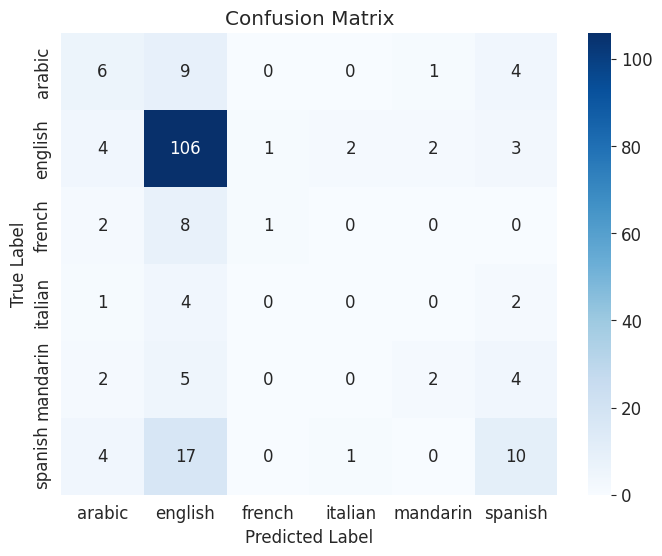

In [15]:
print("\n RESULTS")

loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

ADVANCED VISUALIZATIONS

###### Training Performance (Accuracy & Loss)

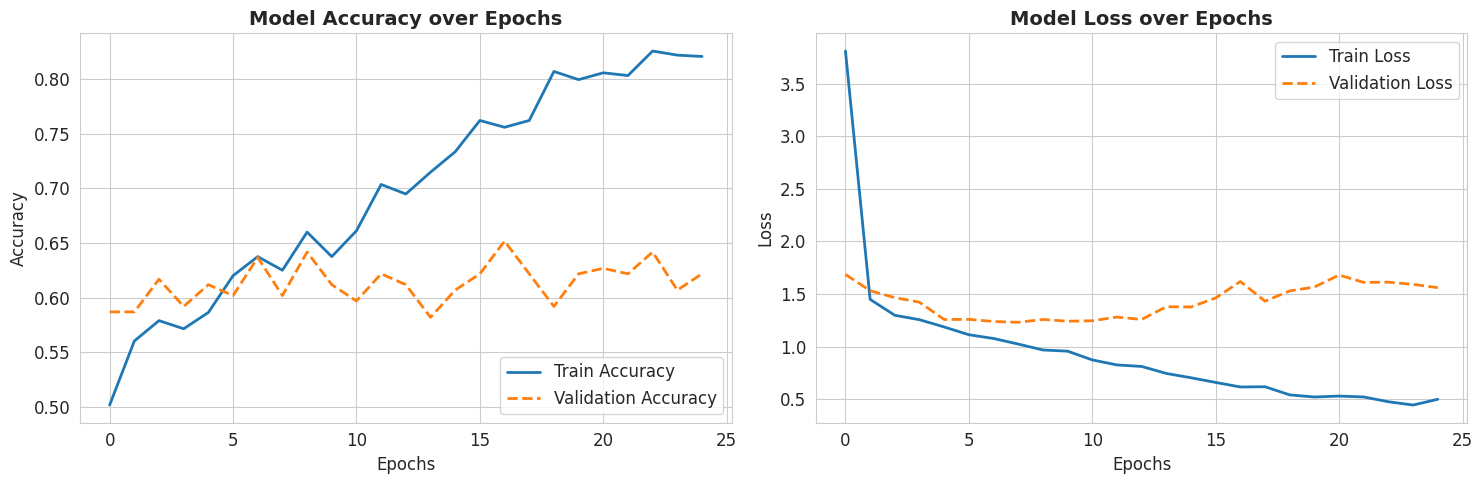

In [16]:
# Setting a professional style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy Plot
    axes[0].plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=2, linestyle='--')
    axes[0].set_title('Model Accuracy over Epochs', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend(loc='lower right')

    # Loss Plot
    axes[1].plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', linewidth=2, linestyle='--')
    axes[1].set_title('Model Loss over Epochs', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(history)


###### Classification Report Heatmap

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


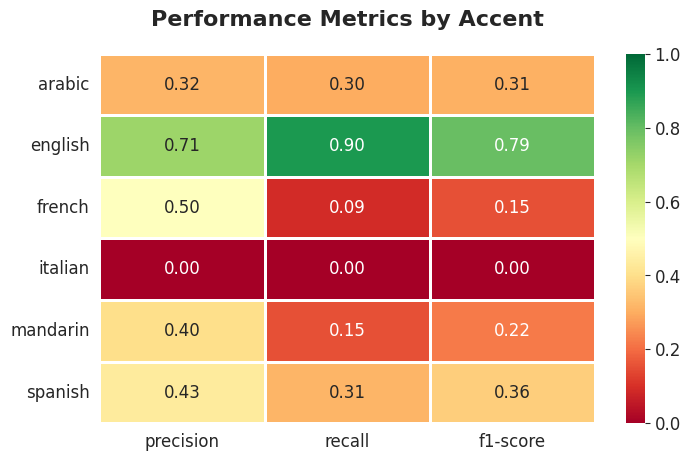

In [17]:
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

def plot_classification_report(model, X_test, y_test, classes):
    y_pred = np.argmax(model.predict(X_test), axis=1)

    # Generate report dictionary
    report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)

    # Convert to DataFrame for visualization
    # Drop 'accuracy', 'macro avg', 'weighted avg' to focus on classes
    df_report = pd.DataFrame(report).transpose()
    df_plot = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])[['precision', 'recall', 'f1-score']]

    plt.figure(figsize=(8, len(classes) * 0.8))
    sns.heatmap(df_plot, annot=True, cmap='RdYlGn', vmin=0, vmax=1,
                linewidths=1, linecolor='white', fmt='.2f')

    plt.title('Performance Metrics by Accent', fontsize=16, fontweight='bold', pad=20)
    plt.yticks(rotation=0)
    plt.show()

plot_classification_report(model, X_test, y_test, label_encoder.classes_)

### YAMNet Transfer Learning

SETTINGUP YAMNET (Pre-trained Model)

In [18]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Loading YAMNet from TensorFlow Hub
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

print("YAMNet loaded successfully!")

YAMNet loaded successfully!


FEATURE EXTRACTION FUNCTION

In [19]:
# Since YAMNet requires 16kHz mono audio. We must resample our data.
def extract_yamnet_embeddings(file_path):
    try:
        # Load audio at 16k sample rate (Required by YAMNet)
        wav_data, sr = librosa.load(file_path, sr=16000, mono=True)

        # Normalize to [-1.0, 1.0] as expected by YAMNet
        wav_data = wav_data / tf.reduce_max(tf.abs(wav_data))

        # Run YAMNet to get scores and embeddings
        # We only care about embeddings (the "features")
        scores, embeddings, spectrogram = yamnet_model(wav_data)

        # YAMNet returns embeddings for every 0.48s chunk.
        # We calculate the MEAN to get one summary vector for the whole file.
        global_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

        return global_embedding
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

PREPARING DATA WITH YAMNET

In [20]:
X_embeddings = []
y_labels = []

print(f"Extracting features using YAMNet for {len(df)} files...")

for i, row in df.iterrows():
    file_path = os.path.join(DATA_PATH, row['filename'] + '.mp3')

    # Extract features using the pre-trained brain
    embedding = extract_yamnet_embeddings(file_path)

    if embedding is not None:
        X_embeddings.append(embedding)
        y_labels.append(row['native_language'])

X_embeddings = np.array(X_embeddings)
y_labels = np.array(y_labels)

# Encode Labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_labels)
y_categorical = to_categorical(y_encoded)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y_categorical, test_size=0.2, random_state=42)

print(f"Features Ready! Shape: {X_train.shape}")

Extracting features using YAMNet for 1004 files...
Features Ready! Shape: (803, 1024)


BUILDING & TRAINING CLASSIFIER

In [21]:
# We now only need a simple classifier because YAMNet did the hard work
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)), # YAMNet outputs size 1024 vectors
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5), # Prevents overfitting
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_data=(X_test, y_test))

loss, acc = model.evaluate(X_test, y_test)
print(f"New Transfer Learning Accuracy: {acc*100:.2f}%")

Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.4797 - loss: 1.5281 - val_accuracy: 0.5871 - val_loss: 1.2922
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5772 - loss: 1.3458 - val_accuracy: 0.5970 - val_loss: 1.2700
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5684 - loss: 1.3227 - val_accuracy: 0.5970 - val_loss: 1.2858
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5600 - loss: 1.3215 - val_accuracy: 0.5871 - val_loss: 1.2669
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5629 - loss: 1.3316 - val_accuracy: 0.5920 - val_loss: 1.2512
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5682 - loss: 1.2758 - val_accuracy: 0.5970 - val_loss: 1.2545
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5855 - loss: 1.2657 - val_accuracy: 0.5920 - val_loss: 1.2401
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5653 - loss: 1.2990 - val_accuracy: 0.5920 - val_los

EVALUATION

In [22]:
loss, acc = model.evaluate(X_test, y_test)
print(f"New Transfer Learning Accuracy: {acc*100:.2f}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5510 - loss: 1.3186 
New Transfer Learning Accuracy: 56.22%


##### Alignment with Proposal: This code implements exactly what you wrote.

##### **Step 1:** Extracting MFCCs and training an SVM.
##### **Step 2:** Using Spectrograms , CNN , and adds noise/pitch augmentation.
##### **Step 3:** Using a pretrained speech encoder (YAMNet) to get embeddings and trains a small classifier.